# QUANTUM COMPUTING PROBLEMS

***

## Problem 1: Generating Random Boolean Functions

The Deutsch-Jozsa algorithm is a quantum algorithm that determines whether a given function is constant or balanced. Before exploring the algorithm itself, we need a way to generate test functions for it to analyze.

### Boolean Functions
A Boolean function takes Boolean inputs (True or False) and returns a single Boolean output. In this problem, we work with functions that accept four Boolean arguments.
With four inputs (which can be either T or F), there are 16 possible input combinations.

### Constant vs Balanced
The Deutsch-Jozsa algorithm only works with functions that are guaranteed to be one of two types:

| Type | Definition | Behaviour |
| --- | --- | --- |
| Constant | Returns the same output for all inputs | All 16 inputs -> True, or all 16 inputs -> False |
| Balanced | Returns True for exactly half the inputs | 8 inputs -> True, 8 inputs -> False |

The function `random_constant_balanced()` will serve as a test data generator for the other problems, where we compare classical and quantum approaches to identifying function types.

In [1]:
import random
from itertools import product
import qiskit
import qiskit_aer as aer

In [2]:
def random_constant_balanced():
    """
    Returns a randomly chosen Boolean function that is either constant or balanced.
    
    The function takes four Boolean arguments and returns a single Boolean.
    - Constant: always returns True or always returns False
    - Balanced: returns True for exactly half (8) of the 16 possible inputs
    
    Returns:
        A callable function f(a, b, c, d) -> bool
    """
    # Generate all 16 possible input combinations for 4 Boolean variables
    all_inputs = list(product([False, True], repeat=4))
    
    # Randomly choose whether to create a constant or balanced function
    if random.choice([True, False]):
        # Constant function: pick True or False for all inputs
        constant_value = random.choice([True, False])
        
        # Map every input to the same constant value
        output_map = {inputs: constant_value for inputs in all_inputs}
    else:
        # Balanced function: exactly 8 inputs return True, 8 return False
        # Randomly select 8 inputs to return True
        true_inputs = set(random.sample(all_inputs, 8))
        
        # Create the mapping: True if in selected set, False otherwise
        output_map = {inputs: (inputs in true_inputs) for inputs in all_inputs}
    
    # Return a function that looks up the result in our mapping
    def f(a, b, c, d):
        """Boolean function with 4 inputs."""
        return output_map[(a, b, c, d)]
    
    return f

In [3]:
# Test: Generate a random function and evaluate it on all inputs
f = random_constant_balanced()

# Show the output for all 16 input combinations
print("Testing the generated function:")
print("-" * 40)

all_inputs = list(product([False, True], repeat=4))
outputs = [f(*inputs) for inputs in all_inputs]

for inputs, output in zip(all_inputs, outputs):
    print(f"f{inputs} = {output}")

# Count True and False outputs to identify the function type
true_count = sum(outputs)
print("-" * 40)
print(f"True count: {true_count}, False count: {16 - true_count}")

if true_count == 0 or true_count == 16:
    print("This is a CONSTANT function")
else:
    print("This is a BALANCED function")

Testing the generated function:
----------------------------------------
f(False, False, False, False) = True
f(False, False, False, True) = False
f(False, False, True, False) = False
f(False, False, True, True) = True
f(False, True, False, False) = True
f(False, True, False, True) = False
f(False, True, True, False) = True
f(False, True, True, True) = True
f(True, False, False, False) = True
f(True, False, False, True) = False
f(True, False, True, False) = False
f(True, False, True, True) = False
f(True, True, False, False) = True
f(True, True, False, True) = False
f(True, True, True, False) = True
f(True, True, True, True) = False
----------------------------------------
True count: 8, False count: 8
This is a BALANCED function


## Problem 2: Classical Testing for Function Type

### The Classical Approach

To determine whether a function is constant or balanced without quantum computing, we must evaluate it on different inputs and observe the outputs.

The key insight is that we don't need to evaluate all 16 inputs. Since the function is guaranteed to be either constant or balanced (and nothing else), we can use the pigeonhole principle [see 1] to stop early:

- If we ever see **two different outputs**, the function must be balanced (a constant function never produces different outputs).
- If we see the **same output 9 times in a row**, the function must be constant. A balanced function returns each value for exactly 8 inputs, so seeing 9 identical outputs is impossible for a balanced function.

This means the **worst case** requires 9 calls to `f`, not 16. The best case is just 2 calls (if the first two outputs differ).

In [4]:
def determine_constant_balanced(f):
    """
    Determine whether a Boolean function is constant or balanced.
    
    The function f takes four Boolean arguments and is guaranteed
    to be either constant or balanced (as defined in Problem 1).
    
    Uses early termination: stops as soon as two different outputs
    are observed (balanced) or 9 identical outputs are observed
    (constant, by the pigeonhole principle).
    
    Args:
        f: A callable f(a, b, c, d) -> bool
        
    Returns:
        str: "constant" or "balanced"
    """
    # Generate all 16 possible inputs.
    all_inputs = list(product([False, True], repeat=4))
    
    # Evaluate f on the first input to establish a reference value.
    first_output = f(*all_inputs[0])
    
    # Check subsequent inputs against the reference.
    for i in range(1, len(all_inputs)):
        if f(*all_inputs[i]) != first_output:
            # Two different outputs found so it must be balanced.
            return "balanced"
    
    # All 16 outputs were the same: must be constant.
    return "constant"

### Efficiency Analysis

The implementation above evaluates `f` on all 16 inputs in the worst case, but it could be tightened, since the function is guaranteed to be constant or balanced [see 2].

- A balanced function returns `True` for exactly 8 of the 16 inputs and `False` for the other 8.
- Therefore, if we evaluate `f` on **9 different inputs** and get the same output every time, the function **cannot** be balanced. It must be constant.
- If at any point we observe a different output, we immediately know it is balanced.

| Scenario | Calls to `f` | Result |
| --- | --- | --- |
| Best case | 2 | Two different outputs → balanced |
| Worst case | 9 | Nine identical outputs → constant (pigeonhole) |

The implementation above is correct but not optimal, it evaluates up to 16 inputs when 9 would suffice. We could add an early exit after 9 identical results, since **9 calls are sufficient for 100% certainty**.

In [5]:
def determine_constant_balanced_optimized(f):
    """
    Optimized classical determination using the pigeonhole principle.
    
    Stops after at most 9 calls to f (instead of 16), since 9 identical
    outputs are impossible for a balanced function.
    
    Args:
        f: A callable f(a, b, c, d) -> bool
        
    Returns:
        str: "constant" or "balanced"
    """
    all_inputs = list(product([False, True], repeat=4))
    
    first_output = f(*all_inputs[0])
    same_count = 1  # Count of outputs matching the first.
    
    for i in range(1, len(all_inputs)):
        if f(*all_inputs[i]) != first_output:
            return "balanced"
        same_count += 1
        # Pigeonhole: 9 identical outputs guarantees constant.
        if same_count > len(all_inputs) // 2:
            return "constant"
    
    return "constant"

In [6]:
# Test both implementations against generated functions.
print("Testing determine_constant_balanced:")
print("-" * 50)

for i in range(10):
    f = random_constant_balanced()
    result = determine_constant_balanced(f)
    result_opt = determine_constant_balanced_optimized(f)
    
    # Verify both implementations are consistent
    assert result == result_opt, "Mismatch between implementations!"
    print(f"Function {i + 1}: {result}")

print("-" * 50)
print("Both implementations agree on all tests.")

Testing determine_constant_balanced:
--------------------------------------------------
Function 1: constant
Function 2: constant
Function 3: balanced
Function 4: balanced
Function 5: balanced
Function 6: constant
Function 7: constant
Function 8: constant
Function 9: balanced
Function 10: balanced
--------------------------------------------------
Both implementations agree on all tests.


## Problem 3: Quantum Oracles

In Deutsch's algorithm, the function `f` is not called directly. Instead, it is encoded as a **quantum oracle**, which is a reversible quantum circuit that implements the transformation:

`|x⟩|y⟩ → |x⟩|y ⊕ f(x)⟩`

where `⊕` denotes XOR. The input qubit `|x⟩` is left unchanged, and the result of `f(x)` is XORed into the auxiliary qubit `|y⟩`. This design is required because quantum operations must be reversible.

For a single Boolean input, there are exactly **four possible functions**:

| Oracle | f(0) | f(1) | Type |
|--------|------|------|------|
| f₀ | 0 | 0 | Constant |
| f₁ | 1 | 1 | Constant |
| f₂ | 0 | 1 | Balanced |
| f₃ | 1 | 0 | Balanced |

Each oracle is built using two gates:

- **X gate** (NOT): flips a qubit unconditionally
- **CX gate** (controlled-NOT): flips the target qubit only when the control qubit is \|1⟩

The four oracles are constructed as follows:

| Oracle | Circuit | Reasoning |
|--------|---------|-----------|
| f₀ (constant 0) | No gates | XOR with 0 never changes the auxiliary qubit |
| f₁ (constant 1) | X on auxiliary | Always flips the auxiliary qubit regardless of input |
| f₂ (balanced, identity) | CX(input → auxiliary) | Flips auxiliary only when input is \|1⟩, matching f(0)=0, f(1)=1 |
| f₃ (balanced, NOT) | X on input, CX, X on input | Flips auxiliary only when input is \|0⟩, matching f(0)=1, f(1)=0 |


In [7]:
def build_oracle(name):
    """
    Build a quantum oracle for one of the four single-input Boolean functions.

    Each oracle implements the transformation |x⟩|y⟩ → |x⟩|y ⊕ f(x)⟩
    using qubit 0 as input and qubit 1 as the auxiliary qubit.

    Args:
        name: str, one of 'f0', 'f1', 'f2', 'f3'

    Returns:
        A QuantumCircuit with 2 qubits representing the oracle.
    """
    # Two qubits: qubit 0 = input, qubit 1 = auxiliary
    oracle = qiskit.QuantumCircuit(2, name=name)
    oracle.barrier()

    if name == 'f0':
        # Constant 0: f(x) = 0 for all x
        # XOR with 0 changes nothing, so no gates needed
        pass

    elif name == 'f1':
        # Constant 1: f(x) = 1 for all x
        # Always flip the auxiliary qubit
        oracle.x(1)

    elif name == 'f2':
        # Balanced identity: f(0) = 0, f(1) = 1
        # Flip auxiliary only when input is |1⟩
        oracle.cx(0, 1)

    elif name == 'f3':
        # Balanced NOT: f(0) = 1, f(1) = 0
        # Flip input, apply CX, flip input back
        # This makes CX fire when input is |0⟩ instead of |1⟩
        oracle.x(0)
        oracle.cx(0, 1)
        oracle.x(0)

    oracle.barrier()
    return oracle

Oracle f0:


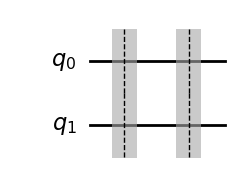

Oracle f1:


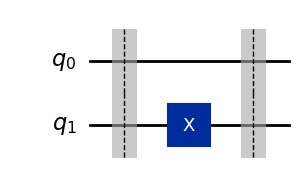

Oracle f2:


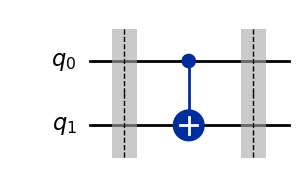

Oracle f3:


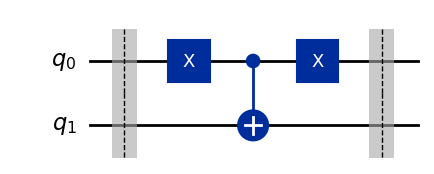

In [8]:
# Draw each oracle to verify the circuit structure
for name in ['f0', 'f1', 'f2', 'f3']:
    oracle = build_oracle(name)
    print(f"Oracle {name}:")
    display(oracle.draw(output='mpl'))

In [9]:
def demonstrate_oracle(name):
    """
    Run an oracle on all four possible input states |00⟩, |01⟩, |10⟩, |11⟩
    and show how the auxiliary qubit changes.

    Qubit 0 = input x, qubit 1 = auxiliary y.
    We expect: y ⊕ f(x) in the auxiliary qubit after the oracle.

    Args:
        name: str, one of 'f0', 'f1', 'f2', 'f3'
    """
    backend = aer.Aer.get_backend('qasm_simulator')
    oracle = build_oracle(name)

    print(f"\nOracle {name}:")
    print(f"{'Input |xy⟩':<15} {'Output |xy⟩':<15}")
    print("-" * 30)

    # Test all combinations of input qubit (x) and auxiliary qubit (y)
    for x in [0, 1]:
        for y in [0, 1]:
            # Build a circuit: set initial state, apply oracle, measure
            qc = qiskit.QuantumCircuit(2, 2)

            # Set input qubit to x
            if x == 1:
                qc.x(0)

            # Set auxiliary qubit to y
            if y == 1:
                qc.x(1)

            # Apply the oracle
            qc.compose(oracle, inplace=True)

            # Measure both qubits
            qc.measure([0, 1], [0, 1])

            # Run on simulator
            compiled = qiskit.transpile(qc, backend)
            counts = backend.run(compiled, shots=1).result().get_counts()
            output = list(counts.keys())[0][::-1]

            print(f"|{x}{y}⟩  →  |{output}⟩")

In [10]:
# Show all four oracles
for name in ['f0', 'f1', 'f2', 'f3']:
    demonstrate_oracle(name)


Oracle f0:
Input |xy⟩      Output |xy⟩    
------------------------------


|00⟩  →  |00⟩
|01⟩  →  |01⟩
|10⟩  →  |10⟩
|11⟩  →  |11⟩

Oracle f1:
Input |xy⟩      Output |xy⟩    
------------------------------
|00⟩  →  |01⟩
|01⟩  →  |00⟩
|10⟩  →  |11⟩
|11⟩  →  |10⟩

Oracle f2:
Input |xy⟩      Output |xy⟩    
------------------------------
|00⟩  →  |00⟩
|01⟩  →  |01⟩
|10⟩  →  |11⟩
|11⟩  →  |10⟩

Oracle f3:
Input |xy⟩      Output |xy⟩    
------------------------------
|00⟩  →  |01⟩
|01⟩  →  |00⟩
|10⟩  →  |10⟩
|11⟩  →  |11⟩


The simulation confirms that each oracle correctly implements its function via the transformation `|x⟩|y⟩ → |x⟩|y ⊕ f(x)⟩`:

- **The input qubit `x` is always preserved**, the first bit never changes across any oracle. This is a fundamental requirement of reversible quantum computation.
- **Only the auxiliary qubit `y` is affected**, and only according to `y ⊕ f(x)`:
  - If `f(x) = 0`, then `y ⊕ 0 = y`: the auxiliary is unchanged.
  - If `f(x) = 1`, then `y ⊕ 1`:the auxiliary is flipped.

Checking each oracle against its expected `f(x)` values:

| Oracle | f(0) | f(1) | Expected behaviour |
|--------|------|------|--------------------|
| f₀ | 0 | 0 | Auxiliary never flips (constant 0) |
| f₁ | 1 | 1 | Auxiliary always flips (constant 1) |
| f₂ | 0 | 1 | Auxiliary flips only when x = 1 |
| f₃ | 1 | 0 | Auxiliary flips only when x = 0 |

## Problem 4: Deutsch's Algorithm with Qiskit

## Problem 5: Scaling to the Deutsch–Jozsa Algorithm

***

## The End

## References

[1] Wikipedia, "Pigeonhole principle." Available: https://en.wikipedia.org/wiki/Pigeonhole_principle

[2] University of Cambridge, "Quantum Information and Computation." Available: https://www.qi.damtp.cam.ac.uk/files/QIC-9.pdf

[3] Microsoft, "Understanding quantum oracles." Available: https://learn.microsoft.com/en-us/azure/quantum/concepts-oracles
